<a href="https://colab.research.google.com/github/BarCodeReader/Machine-Learning/blob/master/de_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

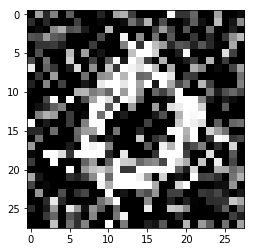

In [105]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

#data
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

#noise data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)


#visualize
plt.imshow(x_test_noisy[3].reshape(28, 28))
plt.gray()
plt.axis('off')

In [0]:
#customized callback
#when val_loss is larger than loss, i.e. overfitting occurs, stop training
class MyCallBack(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('loss')<logs.get('val_loss'):
      self.model.stop_training = True
          
CB = MyCallBack()

In [115]:
#model
input_img = Input(shape=(28, 28, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

#compile the model
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

autoencoder.fit(x_train_noisy, x_train,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks = [CB])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_48 (UpSampling (None, 14, 14, 32)        0         
__________

In [0]:
#test result
decoded_imgs = autoencoder.predict(x_test_noisy)

Text(0.5, 0, 'De-Noise\n(Output)')

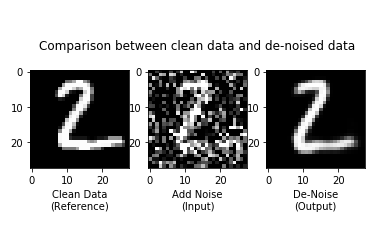

In [117]:
#visualize

N=1

fig=plt.figure()
plt.gray()
plt.axis('off')

fig.add_subplot(1,3,1)
plt.imshow(x_test[N].reshape(28, 28))
plt.xlabel('Clean Data\n(Reference)')

fig.add_subplot(1,3,2)
plt.imshow(x_test_noisy[N].reshape(28, 28))
plt.xlabel('Add Noise\n(Input)')
plt.title('Comparison between clean data and de-noised data\n')

fig.add_subplot(1,3,3)
plt.imshow(decoded_imgs[N].reshape(28, 28))
plt.xlabel('De-Noise\n(Output)')